# AE 352 Team Project Spring 2024: UAV

## Authors: Connor Gordon, Daniel Mena, and Adam Mateja

# Creating Condynsate Visualization Environment

## Import Necessary Libraries

When starting any Python project, the first thing to do is import dependencies. In this project, we will need the ``ae352_quadrotor`` module.

In [1]:
# Import the quadrotor project. This module is used to simulate, render, and plot a quadrotor dynamic system
import ae352_quadrotorUAV

For post processing the data, we will also need the [``numpy``](https://numpy.org/) and [``matplotlib.pyplot``](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) modules.

In [2]:
# Import the pyplot module from the matplotlib package. This is used for graphing data
import matplotlib.pyplot as plt

# Import numpy module. This is used for numerical analysis and manipulation
import numpy as np

We now need to initialize and instance of the simulator. There are four main parameters to the Quadrotor_Sim class initialization function:
#### Parameters

> **use_keyboard** : *bool, optional*  
> A boolean flag that indicates whether the simulation will allow the use of keyboard interactivity. The default is True.
>
> **visualization** : *bool, optional*  
> A boolean flag that indicates whether the simulation will be  visualized in meshcat. The default is True.
>
> **animation** : *bool, optional*  
> A boolean flag that indicates whether animated plots are created in real time. The default is True.
>
>  **verbose** : *bool, optional*  
> A boolean flag that indicates whether warnings are printing during  function execution. The default is False  .

# Creating Mathematical Model

## Defining Quadcopter Geometry

### Finding lift constant $k$

In [3]:
import numpy as np

# Provided arrays of 
rpm = np.array([5954, 7880, 9506, 10569, 11052, 11600, 12127, 13059])
thrust_grams = np.array([628, 977, 1525, 1719, 1976, 2226, 2506, 3021])

# Convert thrust from grams to Newtons
thrust_newtons = thrust_grams * 0.0098

def omega(rpm):
    return rpm * 2 * np.pi / 60

def k_Average(rpm, thrust):
    angular_velocity = omega(rpm)
    k = []
    
    # Calculate the constant k
    for i in range(len(rpm)):
        K_l = thrust[i] / (angular_velocity[i]**2)
        k.append(K_l)
        
    # Calculate the average of all k values
    k_avg = sum(k) / len(k)
    return k_avg

# Calculate k with thrust in Newtons
k_value = k_Average(rpm, thrust_newtons)

print("k in N/(rad²/s²):", k_value)

k in N/(rad²/s²): 1.4878100291924136e-05


### Finding Moments of Inertia of Quadcopter

In [4]:
from sympy import *
import sympy as sym
import numpy as np

m_props = 0.0174 * 4
m_esc = 0.005 * 4
m_receiver = 0.0071

mass_motor = 0.075
radius_motor = 0.034
height_motor = 0.024

def IxxCylinder(m, r, h):
    I1 = (1/4) * m * r**2
    I2 = (1/12) * m * h**2
    return I1 + I2

def IyyCylinder(m, r, h):
    I1 = (1/4) * m * r**2
    I2 = (1/12) * m * h**2
    return I1 + I2

def IzzCylinder(m, r, h):
    I = (1/2) * m * r**2
    return I

def ICylinder(m, r, h):
    I = Matrix([[IxxCylinder(m, r, h), 0, 0], [0, IyyCylinder(m, r, h), 0], [0, 0, IzzCylinder(m, r, h)]])
    return I

#For Rod(Body Components)

radius_body = 0.002
length_body = 0.225
mass_bodyPart = 0.395 / 4

def IxxRod(m, r, l):
    I = 2 * m * ((1/3) * l**2 + r**2)
    return I

def IyyRod(m, r, l):
    return IxxRod(m, r, l)

def IzzRod(m, r, l):
    I = (4/3) * m * l**2
    return I

def IRod(m, r, l):
    I = Matrix([[IxxRod(m, r, l), 0, 0], [0, IyyRod(m, r, l), 0], [0, 0,IzzRod(m, r, l)]])
    return I

#For Rectangular Bar(Battery)

height_battery = 0.044
length_battery = 0.135
width_battery = 0.044
mass_battery = 0.330

def IxxRectangle(m, l, w, h):
    I = (1/12) * m * (h**2 + l**2)
    return I

def IyyRectangle(m, l, w, h):
    I = (1/12) * m * (l**2 + w**2)
    return I

def IzzRectangle(m, l, w, h):
    I = (1/12) * m * (h**2 + l**2)
    return I

def IRectangle(m, l, w, h):
    I = Matrix([[IxxRectangle(m, l, w, h), 0, 0], [0, IyyRectangle(m, l, w, h), 0], [0, 0, IzzRectangle(m, l, w, h)]])
    return I

#To find the total moments of inertia matrices, Parallel Axis Theorem
# I = I_cm + m * d**2

I_Body = IRod(mass_bodyPart, radius_body, length_body)
I_Motor = ICylinder(mass_motor, radius_motor, height_motor)
I_Battery = IRectangle(mass_battery, length_battery, width_battery, height_battery)

def Ixx(b, m, bat):
    B = b[0, 0]
    MPL = m[0, 0] + mass_motor * length_body**2
    MIL = m[0, 0]
    Bat = bat[0, 0] + mass_battery * (height_battery/2)**2
    I = B + Bat + 2 * MPL + 2 * MIL
    return I

def Iyy(b, m, bat):
    B = b[1, 1]
    MPL = m[1, 1] + mass_motor * length_body**2
    MIL = m[1, 1]
    Bat = bat[1, 1] + mass_battery * (height_battery/2)**2
    I = B + Bat + 2 * MPL + 2 * MIL
    return I

def Izz(b, m, bat):
    B = b[2, 2]
    M = m[2, 2] + mass_motor * length_body**2
    Bat = bat[2, 2]
    I = B + Bat + 4 * M
    return I

def I(x, y, z):
    return Matrix([[Ixx(x, y, z), 0, 0], [0, Iyy(x, y, z), 0], [0, 0, Izz(x, y, z)]])

I = I(I_Body, I_Motor, I_Battery)
m_UAV = mass_motor * 4 + mass_battery + mass_bodyPart * 4 + m_props + m_esc + m_receiver
m_UAV
display(sym.Matrix(I))

Matrix([
[0.0117426,         0,            0],
[        0, 0.0117426,            0],
[        0,         0, 0.0225809525]])

## Develop Equations of Motion

In [52]:
# copy from DeriveEOM notebook

import sympy as sym
import numpy as np

m = sym.nsimplify(m_UAV)
Jx = sym.nsimplify(I[0])
Jy = sym.nsimplify(I[4])
Jz = sym.nsimplify(I[8])

print('Moments of Inertia are:')
print(Jx.evalf())
print(Jy.evalf())
print(Jz.evalf())
l = sym.nsimplify(length_body)
g = sym.nsimplify(9.81)

# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# roll, pitch, yaw angles (radians)
phi, theta, psi = sym.symbols('phi, theta, psi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# rotation matrices
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Rxyz = Rx * Ry * Rz
display('R is:', sym.Matrix(Rxyz))

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry * Rz).T * ex, Rz.T * ey, ez).inv(), full=True)

# applied forces
forces = sym.Matrix([[0], [0], [-m * g]]) + Rxyz * sym.Matrix([[0], [0], [f_z]])

# euler's equations
euler = sym.Matrix([[(1 / Jx) * (tau_x + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (tau_y + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (tau_z + (Jx - Jy) * w_x * w_y)]])

# equations of motion
f = sym.Matrix.vstack(sym.Matrix([[v_x], [v_y], [v_z]]),
                      M * sym.Matrix([[w_x], [w_y], [w_z]]),
                      (1 / m) * forces,
                      euler)
f = sym.simplify(f, full=True)

display('f is:', sym.Matrix(f))

Moments of Inertia are:
0.0117426000000000
0.0117426000000000
0.0225809525000000


'R is:'

Matrix([
[                             cos(psi)*cos(theta),                              -sin(psi)*cos(theta),           sin(theta)],
[sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi), -sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi), -sin(phi)*cos(theta)],
[sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi),  sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi),  cos(phi)*cos(theta)]])

'f is:'

Matrix([
[                                                     v_x],
[                                                     v_y],
[                                                     v_z],
[                (w_x*cos(psi) - w_y*sin(psi))/cos(theta)],
[                             w_x*sin(psi) + w_y*cos(psi)],
[-w_x*cos(psi)*tan(theta) + w_y*sin(psi)*tan(theta) + w_z],
[                              10000*f_z*sin(theta)/11217],
[                    -10000*f_z*sin(phi)*cos(theta)/11217],
[           10000*f_z*cos(phi)*cos(theta)/11217 - 981/100],
[           5000000*tau_x/58713 - 4335341*w_y*w_z/4697040],
[           5000000*tau_y/58713 + 4335341*w_x*w_z/4697040],
[                                 400000000*tau_z/9032381]])

In [6]:
# get g

g = sym.Matrix([p_x, p_y, p_z,phi,theta, psi])
g

Matrix([
[  p_x],
[  p_y],
[  p_z],
[  phi],
[theta],
[  psi]])

In [7]:
f_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], f)
g_num = sym.lambdify([p_x, p_y, p_z,phi,theta, psi], g)

# Linearize Model for Implementation in Linear Feedback Controller

## Define Equilibrium Points

In [8]:
p_x_e = 0.
p_y_e = 0.
p_z_e = 0.
psi_e = 0.
theta_e = 0.
phi_e = 0.
v_x_e = 0.
v_y_e = 0.
v_z_e = 0.
w_x_e = 0.
w_y_e = 0.
w_z_e = 0.
tau_x_e = 0.
tau_y_e = 0.
tau_z_e = 0.
f_z_e = 9.81 * m_UAV
print(f_z_e)

11.003877


## Construct A, B, and C Matrices

In [9]:
# Find A and B Matricies
f_jacob_x = f.jacobian([p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z])
f_jacob_u = f.jacobian([tau_x, tau_y, tau_z, f_z])

A_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z),f_jacob_x)
B_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z),f_jacob_u)


A = A_num(p_x_e, p_y_e, p_z_e, phi_e, theta_e, psi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, f_z_e)
B = B_num(p_x_e, p_y_e, p_z_e, phi_e, theta_e, psi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, f_z_e)

In [10]:
# Get C matrix

g_jacob_x = g.jacobian([p_x, p_y, p_z, phi, theta, psi,v_x, v_y, v_z, w_x, w_y, w_z])
g_jacob_u = g.jacobian([tau_x, tau_y, tau_z, f_z])

C_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z),g_jacob_x)
D_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z),g_jacob_u)

C = C_num(p_x_e, p_y_e, p_z_e, phi_e, theta_e, psi_e,v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, f_z_e)
D = D_num(p_x_e, p_y_e, p_z_e, phi_e, theta_e, psi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, f_z_e)
print(f'Dimensions of C matrix is: {np.shape(C)}')
print(f'Dimensions of D matrix is: {np.shape(D)}')

Dimensions of C matrix is: (6, 12)
Dimensions of D matrix is: (6, 4)


## Construct Gain Matrices: $K$ and $L$

In [11]:
# Design controller
import scipy as scipy

Q_controller = np.diag([10.,50.,10.,48.,48.,48.,8.,16.,8.,16.,16.,16.])
#R_controller = np.diag([200.,200.,200.,4.])

#Q_controller = np.diag([14,14,14,5,5,5,10000,10000,10000,100,100,100])

R_controller = np.diag([1/(0.03)**2, 1/(0.03)**2, 1/(0.03)**2, 1/(15)**2])

P_controller = scipy.linalg.solve_continuous_are(A, B, Q_controller, R_controller)
K = np.linalg.inv(R_controller) @  B.T @ P_controller

In [12]:
# design observer
Q_observer = 1000*np.diag(np.ones(6))
R_observer = np.diag(np.ones(12))

#Q_observer= np.identity(6)

#R_observer = np.eye(12)

P_observer = scipy.linalg.solve_continuous_are(A.T, C.T, np.linalg.inv(R_observer), np.linalg.inv(Q_observer))
L = (Q_observer @ C @ P_observer.T).T

print(f'Shape of L is: {np.shape(L)}')
L

Shape of L is: (12, 6)


array([[ 3.26526617e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.50319929e-01,  0.00000000e+00],
       [ 0.00000000e+00,  3.26526617e+01,  0.00000000e+00,
        -1.50319929e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  3.26074463e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.50319929e-01,  0.00000000e+00,
         3.26070998e+01,  0.00000000e+00,  0.00000000e+00],
       [ 1.50319929e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.26070998e+01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.26074463e+01],
       [ 3.31094562e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  9.80649686e+00,  0.00000000e+00],
       [ 0.00000000e+00,  3.31094562e+01,  0.00000000e+00,
        -9.80649686e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  3.162

# Build a Linear State Feedback Controller

The next step is to make a piece of code that can apply inputs (forces and torques) to the quadrotor. Now that the simulator is created, we can make our own controller. In the scope of AE352 and AE353, all controllers will have the same format as the one below. Specifically, all controllers will be a class that includes **exactly** three functions:
```python
def __init__(self)
def reset(self)
def run(self, **kwargs)
```
Descriptions for these functions are provided below in the ``Controller`` class.

As set up currently, this ``Controller`` class listens to your keyboard inputs and adjusts the forces and torques applied to the quadrotor. You can change how this works by modifying the output of the ``run`` function.

## Develop Path Planning Code to Fulfill Performance Goals

### Performance Goal 2

In [13]:
# defining function for path problem 1
def getTarget1(t):
    r = 2
    Z = t/(2*r)
    xpos = r*np.cos(Z)
    ypos = r*np.sin(Z)
    zpos = 1
    return np.array([[xpos],[ypos],[zpos],[0],[0],[0],[0],[0],[0],[0],[0],[0]])

### Performance Goal 3

In [14]:
# defining function for path problem 2
def getTarget2(t):
    vec = np.zeros(12).reshape(12,1)
    if t <= 1:
        # increase altitude to z=1
        vec[2] = 1
    elif t <= 6:
        # fly in a line for 5s
        vec[1] = 5
        vec[2] = 1
    elif t<= 7:
        vec[1] = 5
        vec[2] = 1
    elif t <= 9:
        vec[1] = 5
        vec[2] = 1
        vec[5] = np.pi/2
    elif t <= 15:
        vec[0] = 5
        vec[1] = 5
        vec[2] = 1
    else:
        vec[0] = 5
        vec[1] = 5
        vec[2] = 0

    return vec

## Construcing Controller to Model Flight and Extract Angular Velocities

### For Performance Goal 1

In [15]:
general_motor1 = []

# Create the Controller class
class Controller():
    def __init__(self):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.

        Parameters
        ----------
        None.

        Returns
        -------
        None.
        """

        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L

        self.f_z_e = 9.81 * m_UAV

    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be
        called just before the simulation starts running and any time the simulation
        is reset.

        Parameters
        ----------
        None.

        Returns
        -------
        None.
        """
        # Fixme: Implement your reset function here
        self.xhat = np.zeros(12).reshape((12,1))
        #self.xhat[2] = 1


    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement

        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["dt"] : float
                The simulation time step in seconds.

            kwargs["time"] : float
                The current simulation time in seconds.

        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there are four inputs, tau_x, tau_y, tau_z, f_z.
            Therefore, inputs has the form:
            inputs = [tau_x, tau_y, tau_z, f_z]

        """

        world_state = sim.sim.get_base_state(urdf_obj=sim.quad_obj)
        pos = world_state['position']
        rpy = [world_state['roll'],
                       world_state['pitch'],
                       world_state['yaw']]
        velocity = world_state['velocity']
        angular_velocity = world_state['angular velocity']

        self.dt = kwargs["dt"]

        # Define path planning target for simulation
        # Varies for each Performance Requirement

        # ## FOR PROBLEM 1 ##
        target = np.array([[0],[0],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0]])

        ## FOR PROBLEM 2 ##
        # target = getTarget1(kwargs["time"])

        ## FOR PROBLEM 3 ##
        # target = getTarget2(kwargs["time"])


        y = np.array([[pos[0]], [pos[1]], [pos[2]], [rpy[0]], [rpy[1]], [rpy[2]]]) #Sensor data
        dist = np.linalg.norm([[target[0] - pos[0]], [target[1] - pos[1]], [target[2] - pos[2]]]) #Distance between current and desired
        displace_vec = ([[target[0] - pos[0]], [target[1] - pos[1]], [target[2] - pos[2]]])/dist #Unit displacement vector

        # DIRECTION TO GO
        v_vect = displace_vec * (dist)**2 * 0.06 #Variable velocity vector

        x_des = target


        u = -self.K @ (self.xhat - x_des)
        tau_x = u[0,0]
        tau_y = u[1,0]
        tau_z = u[2,0]
        f_z = u[3,0] + self.f_z_e
        #f_z = self.f_z_e

        ## EXTRACT ROTOR VALUES BASED ON TORQUES ##

        # constants
        #k = 1.5 * 10**-6
        k = 1.4878100291924136e-05
        b = 1 * 10**-7

        f_ext = np.array([tau_x,tau_y,tau_z,f_z]).T
        A_ext = Matrix([[0,-l*k,0,l*k], [-l*k,0,l*k,0], [b,-b,b,-b], [k,k,k,k]])
        x_ext = A_ext.inv() @ f_ext
        w1 = np.real(sqrt(x_ext[0]))
        w2 = np.real(sqrt(x_ext[1]))
        w3 = np.real(sqrt(x_ext[2]))
        w4 = np.real(sqrt(x_ext[3]))

        general_motor1.append([w1,w2,w3,w4])

        ## CONTINUE ##

        u[3,0] = f_z - self.f_z_e
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)) #State estimation

        print('Fz is:', f_z)
        # return controls
        return [tau_x, tau_y, tau_z, f_z]

In [16]:
# Create an instance of the controller for Performance Goal 1
controller1 = Controller()

### Performance Goal 2

In [17]:
general_motor2 = []

# Create the Controller class
class Controller():
    def __init__(self):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.

        Parameters
        ----------
        None.

        Returns
        -------
        None.
        """

        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L

        self.f_z_e = 9.81 * m_UAV

    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be
        called just before the simulation starts running and any time the simulation
        is reset.

        Parameters
        ----------
        None.

        Returns
        -------
        None.
        """
        # Fixme: Implement your reset function here
        self.xhat = np.zeros(12).reshape((12,1))
        #self.xhat[2] = 1


    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement

        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["dt"] : float
                The simulation time step in seconds.

            kwargs["time"] : float
                The current simulation time in seconds.

        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there are four inputs, tau_x, tau_y, tau_z, f_z.
            Therefore, inputs has the form:
            inputs = [tau_x, tau_y, tau_z, f_z]

        """

        world_state = sim.sim.get_base_state(urdf_obj=sim.quad_obj)
        pos = world_state['position']
        rpy = [world_state['roll'],
                       world_state['pitch'],
                       world_state['yaw']]
        velocity = world_state['velocity']
        angular_velocity = world_state['angular velocity']

        self.dt = kwargs["dt"]

        # Define path planning target for simulation
        # Varies for each Performance Requirement

        # ## FOR PROBLEM 1 ##
        # target = np.array([[0],[0],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0]])

        ## FOR PROBLEM 2 ##
        target = getTarget1(kwargs["time"])

        ## FOR PROBLEM 3 ##
        # target = getTarget2(kwargs["time"])


        y = np.array([[pos[0]], [pos[1]], [pos[2]], [rpy[0]], [rpy[1]], [rpy[2]]]) #Sensor data
        dist = np.linalg.norm([[target[0] - pos[0]], [target[1] - pos[1]], [target[2] - pos[2]]]) #Distance between current and desired
        displace_vec = ([[target[0] - pos[0]], [target[1] - pos[1]], [target[2] - pos[2]]])/dist #Unit displacement vector

        # DIRECTION TO GO
        v_vect = displace_vec * (dist)**2 * 0.06 #Variable velocity vector

        x_des = target


        u = -self.K @ (self.xhat - x_des)
        tau_x = u[0,0]
        tau_y = u[1,0]
        tau_z = u[2,0]
        f_z = u[3,0] + self.f_z_e
        #f_z = self.f_z_e

        ## EXTRACT ROTOR VALUES BASED ON TORQUES ##

        # constants
        #k = 1.5 * 10**-6
        k = 1.4878100291924136e-05
        b = 1 * 10**-7

        f_ext = np.array([tau_x,tau_y,tau_z,f_z]).T
        A_ext = Matrix([[0,-l*k,0,l*k], [-l*k,0,l*k,0], [b,-b,b,-b], [k,k,k,k]])
        x_ext = A_ext.inv() @ f_ext
        w1 = np.real(sqrt(x_ext[0]))
        w2 = np.real(sqrt(x_ext[1]))
        w3 = np.real(sqrt(x_ext[2]))
        w4 = np.real(sqrt(x_ext[3]))

        general_motor2.append([w1,w2,w3,w4])

        ## CONTINUE ##

        u[3,0] = f_z - self.f_z_e
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)) #State estimation

        print('Fz is:', f_z)
        # return controls
        return [tau_x, tau_y, tau_z, f_z]

In [18]:
# Create an instance of the controller for Performance Goal 2
controller2 = Controller()

### Performance Goal 3

In [19]:
general_motor3 = []

# Create the Controller class
class Controller():
    def __init__(self):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.

        Parameters
        ----------
        None.

        Returns
        -------
        None.
        """

        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L

        self.f_z_e = 9.81 * m_UAV

    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be
        called just before the simulation starts running and any time the simulation
        is reset.

        Parameters
        ----------
        None.

        Returns
        -------
        None.
        """
        # Fixme: Implement your reset function here
        self.xhat = np.zeros(12).reshape((12,1))
        #self.xhat[2] = 1


    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement

        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["dt"] : float
                The simulation time step in seconds.

            kwargs["time"] : float
                The current simulation time in seconds.

        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there are four inputs, tau_x, tau_y, tau_z, f_z.
            Therefore, inputs has the form:
            inputs = [tau_x, tau_y, tau_z, f_z]

        """

        world_state = sim.sim.get_base_state(urdf_obj=sim.quad_obj)
        pos = world_state['position']
        rpy = [world_state['roll'],
                       world_state['pitch'],
                       world_state['yaw']]
        velocity = world_state['velocity']
        angular_velocity = world_state['angular velocity']

        self.dt = kwargs["dt"]

        # Define path planning target for simulation
        # Varies for each Performance Requirement

        # ## FOR PROBLEM 1 ##
        # target = np.array([[0],[0],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0]])

        ## FOR PROBLEM 2 ##
        # target = getTarget1(kwargs["time"])

        ## FOR PROBLEM 3 ##
        target = getTarget2(kwargs["time"])


        y = np.array([[pos[0]], [pos[1]], [pos[2]], [rpy[0]], [rpy[1]], [rpy[2]]]) #Sensor data
        dist = np.linalg.norm([[target[0] - pos[0]], [target[1] - pos[1]], [target[2] - pos[2]]]) #Distance between current and desired
        displace_vec = ([[target[0] - pos[0]], [target[1] - pos[1]], [target[2] - pos[2]]])/dist #Unit displacement vector

        # DIRECTION TO GO
        v_vect = displace_vec * (dist)**2 * 0.06 #Variable velocity vector

        x_des = target


        u = -self.K @ (self.xhat - x_des)
        tau_x = u[0,0]
        tau_y = u[1,0]
        tau_z = u[2,0]
        f_z = u[3,0] + self.f_z_e
        #f_z = self.f_z_e

        ## EXTRACT ROTOR VALUES BASED ON TORQUES ##

        # constants
        #k = 1.5 * 10**-6
        k = 1.4878100291924136e-05
        b = 1 * 10**-7

        f_ext = np.array([tau_x,tau_y,tau_z,f_z]).T
        A_ext = Matrix([[0,-l*k,0,l*k], [-l*k,0,l*k,0], [b,-b,b,-b], [k,k,k,k]])
        x_ext = A_ext.inv() @ f_ext
        w1 = sqrt(np.abs(x_ext[0]))
        w2 = sqrt(np.abs(x_ext[1]))
        w3 = sqrt(np.abs(x_ext[2]))
        w4 = sqrt(np.abs(x_ext[3]))

        general_motor3.append([w1,w2,w3,w4])

        ## CONTINUE ##

        u[3,0] = f_z - self.f_z_e
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)) #State estimation

        print('Fz is:', f_z)
        # return controls
        return [tau_x, tau_y, tau_z, f_z]

In [20]:
# Create an instance of the controller for Performance Goal 3
controller3 = Controller()

# Verifying Performance Goals and Engineering Requirements

## Performance Goal 1

### Running Simulation and Collecting Data

In [21]:
sim = ae352_quadrotorUAV.Quadrotor_Sim(use_keyboard=True,
                                       visualization=False,
                                       animation=False,
                                       verbose=True)

In [22]:
data = sim.run(controller1,
                collect_data=True,
                max_time=120.0,
                verbose=True)

Fz is: 58.43804190252604
Fz is: 39.97415520953322
Fz is: 28.49074022754615
Fz is: 21.4647493666907
Fz is: 17.24029791731765
Fz is: 14.747245590914243
Fz is: 13.304610117322273
Fz is: 12.485929344757022
Fz is: 12.030971874216153
Fz is: 11.784532281891284
Fz is: 11.65509319943936
Fz is: 11.589425968332403
Fz is: 11.557103393255144
Fz is: 11.54112250823555
Fz is: 11.53227312765559
Fz is: 11.525788545840154
Fz is: 11.519376743841153
Fz is: 11.512079742744032
Fz is: 11.503624849718282
Fz is: 11.494064585245706
Fz is: 11.483583524430617
Fz is: 11.472399823826958
Fz is: 11.460719114285244
Fz is: 11.448716341720836
Fz is: 11.436531741657827
Fz is: 11.424273335853623
Fz is: 11.412021910421341
Fz is: 11.39983644949518
Fz is: 11.38775910427854
Fz is: 11.375819360997657
Fz is: 11.364037361276527
Fz is: 11.3524264578888
Fz is: 11.340995134040856
Fz is: 11.329748418092752
Fz is: 11.318688911227245
Fz is: 11.30781752517873
Fz is: 11.297134006646726
Fz is: 11.286637306979618
Fz is: 11.276325840906626


### Plotting Angular Velocity of Each Rotor over Time

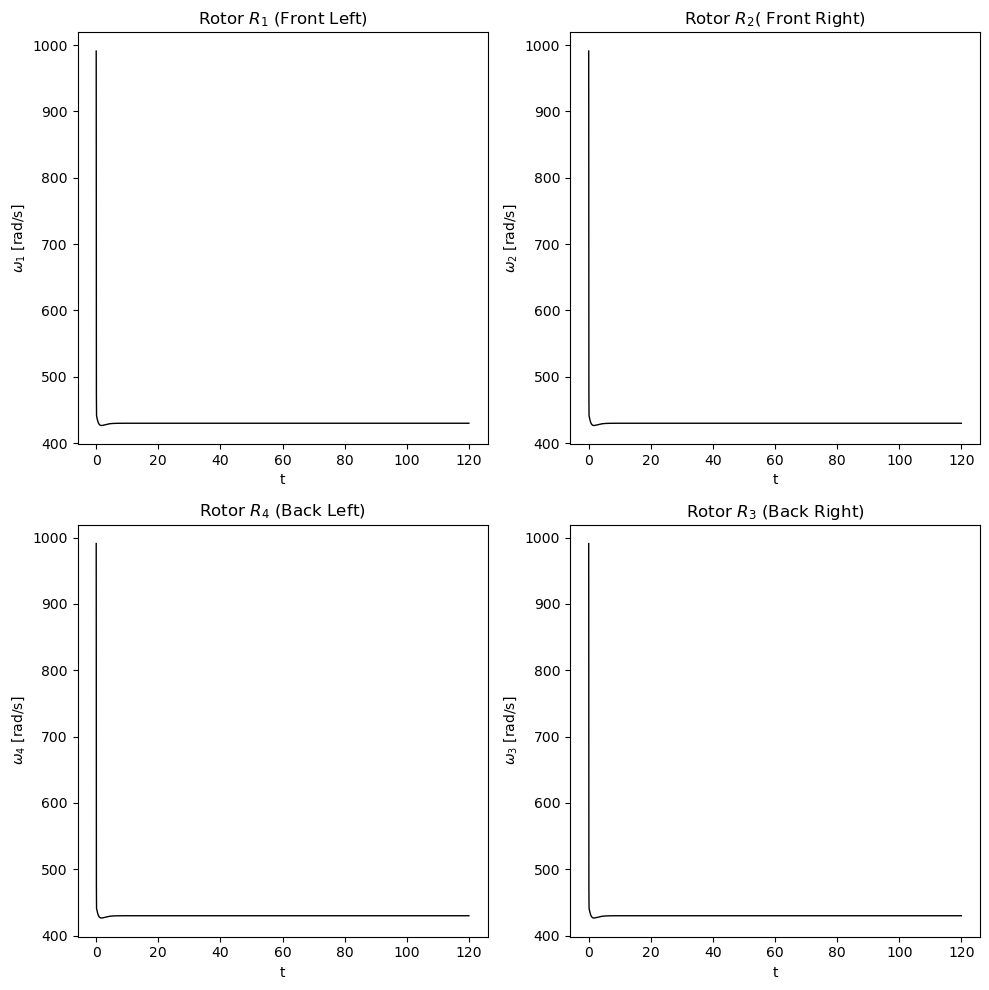

990.932542789155
990.932542789155
990.932542789155
990.932542789155


In [23]:
# plot motor data over time:
motor_vals1 = np.array(np.real(general_motor1)).T


fig = plt.figure(figsize=(10, 10), tight_layout=True)

axs1 = fig.add_subplot(221)
axs1.plot(data['time'],motor_vals1[0],c='black',lw=1,label='Front left motor (#1)')
axs1.set_title("Rotor $R_1$ (Front Left)")
axs1.set_ylabel("$\omega_1$ [rad/s]")
axs1.set_xlabel("t")
#axs1.set_ylim(420, 460)
#axs1.set_xlim(0, 2)

axs2 = fig.add_subplot(222)
axs2.plot(data['time'],motor_vals1[1],c='black',lw=1,label='Front right motor (#2)')
axs2.set_title("Rotor $R_2$( Front Right)")
axs2.set_ylabel("$\omega_2$ [rad/s]")
axs2.set_xlabel("t")
#axs2.set_ylim(420, 460)
#axs2.set_xlim(0, 2)

axs3 = fig.add_subplot(224)
axs3.plot(data['time'],motor_vals1[2],c='black',lw=1,label='Back right motor (#3)')
axs3.set_title("Rotor $R_3$ (Back Right)")
axs3.set_ylabel("$\omega_3$ [rad/s]")
axs3.set_xlabel("t")
#axs3.set_ylim(420, 460)
#axs3.set_xlim(0, 2)

axs4 = fig.add_subplot(223)
axs4.plot(data['time'],motor_vals1[3],c='black',lw=1,label='Back left motor (#4)')
axs4.set_title("Rotor $R_4$ (Back Left)")
axs4.set_ylabel('$\omega_4$ [rad/s]')
axs4.set_xlabel("t")
#axs4.set_ylim(420, 460)
#axs4.set_xlim(0, 2)

plt.show()

print(np.max(motor_vals1[0]))
print(np.max(motor_vals1[1]))
print(np.max(motor_vals1[2]))
print(np.max(motor_vals1[3]))

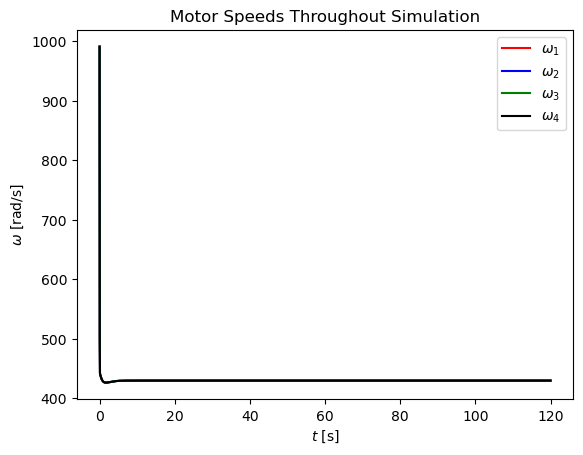

In [24]:
## Plot motor values together to see dependence:

plt.title("Motor Speeds Throughout Simulation")
plt.plot(data['time'],motor_vals1[0],c='red',label='$\omega_1$')
plt.plot(data['time'],motor_vals1[1],c='blue',label='$\omega_2$')
plt.plot(data['time'],motor_vals1[2],c='green',label='$\omega_3$')
plt.plot(data['time'],motor_vals1[3],c='black',label='$\omega_4$')
plt.xlabel("$t$ [s]")
plt.ylabel("$\omega$ [rad/s]")
#plt.ylim(429.975, 430.025)
#plt.xlim(21, 25)
plt.legend()
plt.show()

### Plotting Drone's Motion

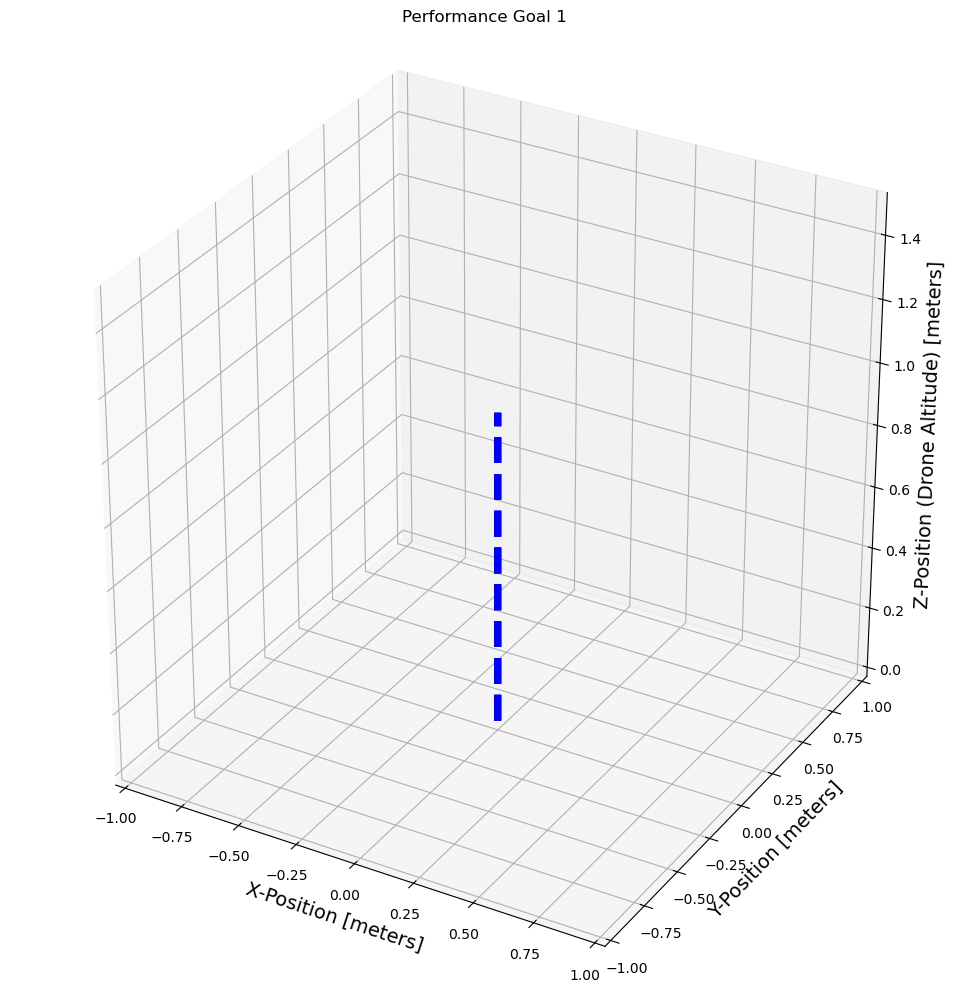

In [25]:
# Create a plot
fig, ax = plt.figure(figsize=(10, 10)), plt.axes(projection = '3d')

# First, extract data for drone position
for n in range(len(data)):
    # Get data for position of drone at diffferent times
    drone_position = np.array(data["position"])
    x_pos = drone_position[:, 0]
    y_pos = drone_position[:, 1]
    z_pos = drone_position[:, 2]

    # Now plot position over time
    ax.plot3D(x_pos, y_pos, z_pos, 'b--', lw = 5.0, label = "Drone Path")
    
# Now add titles
ax.set_xlabel('X-Position [meters]', fontsize = 14)
ax.set_ylabel('Y-Position [meters]', fontsize = 14)
ax.set_zlabel('Z-Position (Drone Altitude) [meters]', fontsize = 14)
ax.grid()
ax.set_box_aspect([1,1,1])
#ax.legend(shadow=True, fancybox=True)
ax.set_title("Performance Goal 1")

# Now add Limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(0, 1.5)
plt.tight_layout()
plt.show()

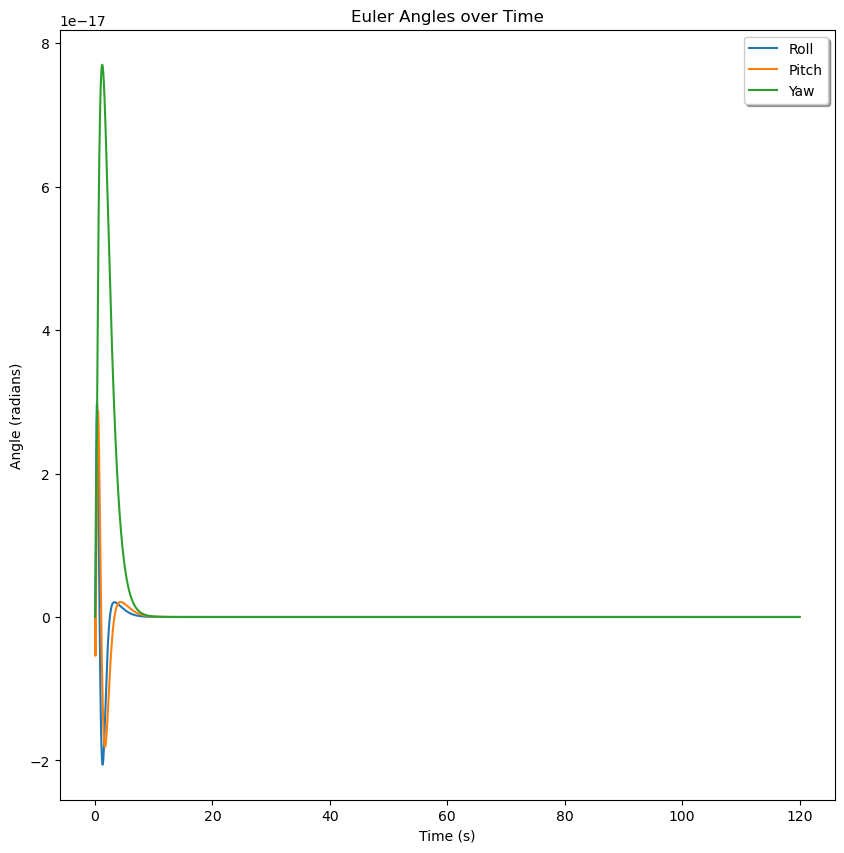

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Extract Euler angles
euler = data["orientation"]

roll = [arr[0] for arr in euler]
pitch = [arr[1] for arr in euler]
yaw = [arr[2] for arr in euler]

# Create a plot with defined size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Euler angles against time
ax.plot(data["time"], roll, label='Roll')
ax.plot(data["time"], pitch, label='Pitch')
ax.plot(data["time"], yaw, label='Yaw')

# Set axis labels
ax.set_xlabel("Time (s)")
ax.set_ylabel("Angle (radians)")

# Set title
ax.set_title("Euler Angles over Time")

# Add a legend with a shadow box
ax.legend(loc='best', shadow=True)  # 'best' places the legend in the optimal position

# Display the plot
plt.show()

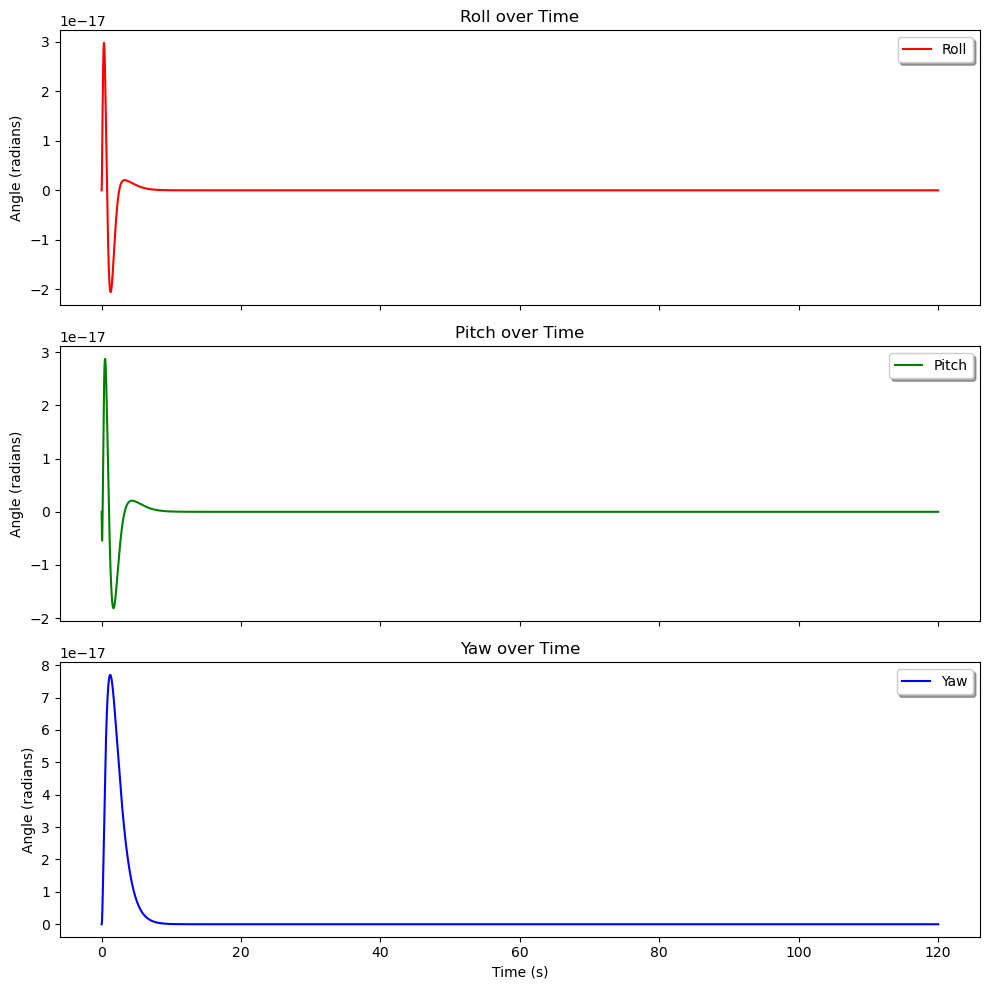

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Extract Euler angles
euler = data["orientation"]

roll = [arr[0] for arr in euler]
pitch = [arr[1] for arr in euler]
yaw = [arr[2] for arr in euler]

# Create a figure with three subplots (1 column and 3 rows)
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)  # sharex=True to share the x-axis

# Subplot for Roll
axes[0].plot(data["time"], roll, color='r', label='Roll')
axes[0].set_ylabel("Angle (radians)")
axes[0].set_title("Roll over Time")
axes[0].legend(loc='best', shadow=True)

# Subplot for Pitch
axes[1].plot(data["time"], pitch, color='g', label='Pitch')
axes[1].set_ylabel("Angle (radians)")
axes[1].set_title("Pitch over Time")
axes[1].legend(loc='best', shadow=True)

# Subplot for Yaw
axes[2].plot(data["time"], yaw, color='b', label='Yaw')
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Angle (radians)")
axes[2].set_title("Yaw over Time")
axes[2].legend(loc='best', shadow=True)

# Show the plot with the three subplots
plt.tight_layout()  # Adjusts subplot params to give some padding
plt.show()


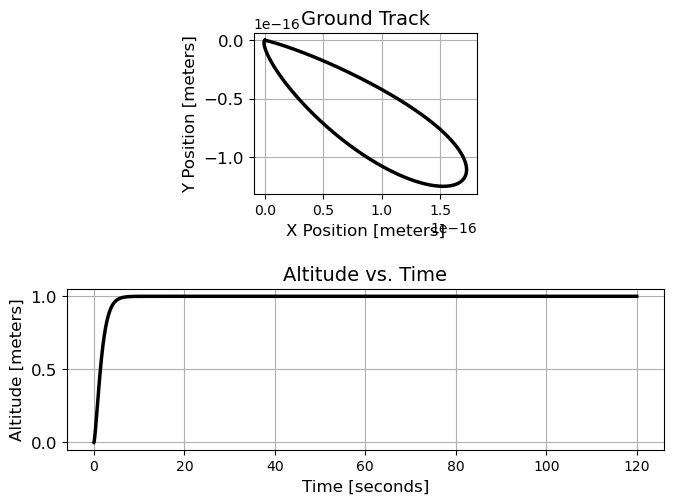

In [28]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=False)

# Convert the position data to array
# Get the position
pos = np.array(data['position'])

# Create a plot of the ground path of the quadrotor
axes[0].plot(pos[:,0], pos[:,1], c="k", lw=2.5)

# Create a plot of the altitude versus time
axes[1].plot(data['time'], pos[:,2], c="k", lw=2.5)

# Make plot 0 pretty
axes[0].set_xlabel("X Position [meters]", fontsize=12)
axes[0].set_ylabel("Y Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].grid()

# Make plot 1 pretty
axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("Altitude [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()

In [29]:
import numpy as np

# Provided arrays of 
rpm = np.array([5954, 7880, 9506, 10569, 11052, 11600, 12127, 13059])
thrust_grams = np.array([628, 977, 1525, 1719, 1976, 2226, 2506, 3021])

# Convert thrust from grams to Newtons
thrust_newtons = thrust_grams * 0.0098

def omega(rpm):
    return rpm * 2 * np.pi / 60

def k_Average(rpm, thrust):
    angular_velocity = omega(rpm)
    k = []
    
    # Calculate the constant k
    for i in range(len(rpm)):
        K_l = thrust[i] / (angular_velocity[i]**2)
        k.append(K_l)
        
    # Calculate the average of all k values
    k_avg = sum(k) / len(k)
    return k_avg

# Calculate k with thrust in Newtons
k_value = k_Average(rpm, thrust_newtons)

print("k in N/(rad²/s²):", k_value)

k in N/(rad²/s²): 1.4878100291924136e-05


### Verifying Engineering Requirement 3

<class 'list'>
Maximum current drawn by motor is 59.6 amps
Maximum current is within threshold, battery does not overheat


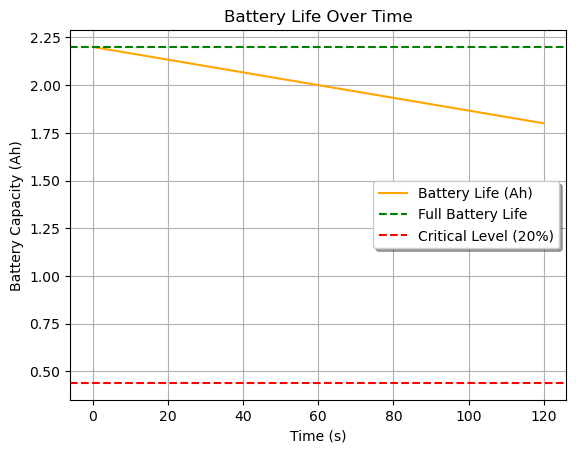

In [30]:
import numpy as np
import matplotlib.pyplot as plt

motor_vals_rpm1 = motor_vals1 * 60 / (2 * np.pi)

time_step = 0.01  # Time step in seconds

# Battery capacity in ampere-hours
battery_capacity_ah = 2.2

# Create function to get amps drawn by battery
def rpm_to_current(rpm_list):
    amp_list = []
    for rpm in rpm_list:
        if rpm <= 5954:
            amps = 3.0
        elif 5954 < rpm <= 7880:
            amps = 6.2
        elif 7880 < rpm <= 9506:
            amps = 14.9
        elif 9506 < rpm <= 10569:
            amps = 17.7
        elif 10569 < rpm <= 11052:
            amps = 23.6
        elif 11052 < rpm:
            amps = 27.2
        amp_list.append(amps)
    return amp_list

# Get lists of amps drawn by each motor
amp_list1 = rpm_to_current(motor_vals_rpm1[0])
print(type(amp_list1))
amp_list2 = rpm_to_current(motor_vals_rpm1[1])
amp_list3 = rpm_to_current(motor_vals_rpm1[2])
amp_list4 = rpm_to_current(motor_vals_rpm1[3])

# Create loss of power due to each motor
battery_life = []
for i in range(len(amp_list1)):
    if i == 0:
        battery_life.append(2.2)
    else:
        battery_loss = (amp_list1[i] + amp_list2[i] + amp_list3[i] + amp_list4[i]) * (time_step / 3600)
        battery_life.append(battery_life[-1] - battery_loss)

# Find maximum current drawn by four motors (done by finding max current for each motor)
max_motor1 = np.max(amp_list1)
max_motor2 = np.max(amp_list2)
max_motor3 = np.max(amp_list3)
max_motor4 = np.max(amp_list4)
max_current = max_motor1 + max_motor2 + max_motor3 + max_motor4
print('Maximum current drawn by motor is', max_current, 'amps')

# Ensure battery does not overheat
if max_current < (35 * 2.2):
    print('Maximum current is within threshold, battery does not overheat')
else:
    print('Maximum current is NOT within threshold, BATTERY OVERHEATS')



# Plot battery life over time
plt.figure()
plt.plot(data["time"], battery_life, color = 'orange', label = "Battery Life (Ah)")
plt.xlabel("Time (s)")
plt.ylabel("Battery Capacity (Ah)")
plt.title("Battery Life Over Time")
plt.axhline(2.2, color = 'green', linestyle = '--', label = 'Full Battery Life')  # Critical level at 20% (2.2 * 0.20)
plt.axhline(0.44, color = 'red', linestyle = '--', label = 'Critical Level (20%)')  # Critical level at 20% (2.2 * 0.20)
plt.legend(shadow = True)
plt.grid(True)
plt.show()

## Performance Goal 2

### Running Simulation and Collecting Data

In [31]:
# Make an instance of the simulator
sim = ae352_quadrotorUAV.Quadrotor_Sim(use_keyboard=True,
                                    visualization=False,
                                    animation=False,
                                    verbose=True)

In [32]:
# Run the simulation and collect the simulation data
data = sim.run(controller2,
               collect_data=True,
               max_time=60.0,
               verbose=True)

Fz is: 58.43804190252331
Fz is: 39.974155209531595
Fz is: 28.49074022754523
Fz is: 21.464749366996276
Fz is: 17.24029792216916
Fz is: 14.74724562251031
Fz is: 13.304610249344218
Fz is: 12.485929764253523
Fz is: 12.030972952737766
Fz is: 11.784534667814423
Fz is: 11.655097950338675
Fz is: 11.58943472771016
Fz is: 11.557118613650648
Fz is: 11.54114771620517
Fz is: 11.532313213112278
Fz is: 11.52585005063884
Fz is: 11.519468127273324
Fz is: 11.512211607628469
Fz is: 11.503810118361695
Fz is: 11.494318619469443
Fz is: 11.48392418792174
Fz is: 11.472847488203914
Fz is: 11.461296612513745
Fz is: 11.449448873993855
Fz is: 11.437446739708722
Fz is: 11.425400292051375
Fz is: 11.413392178029628
Fz is: 11.401483020268092
Fz is: 11.38971636919742
Fz is: 11.378122859487714
Fz is: 11.3667235237217
Fz is: 11.355532345722512
Fz is: 11.344558181150557
Fz is: 11.333806176752969
Fz is: 11.323278805279845
Fz is: 11.312976612716614
Fz is: 11.30289875403319
Fz is: 11.293043375650516
Fz is: 11.28340788805753

### Plotting Angular Velocity of Each Rotor over Time

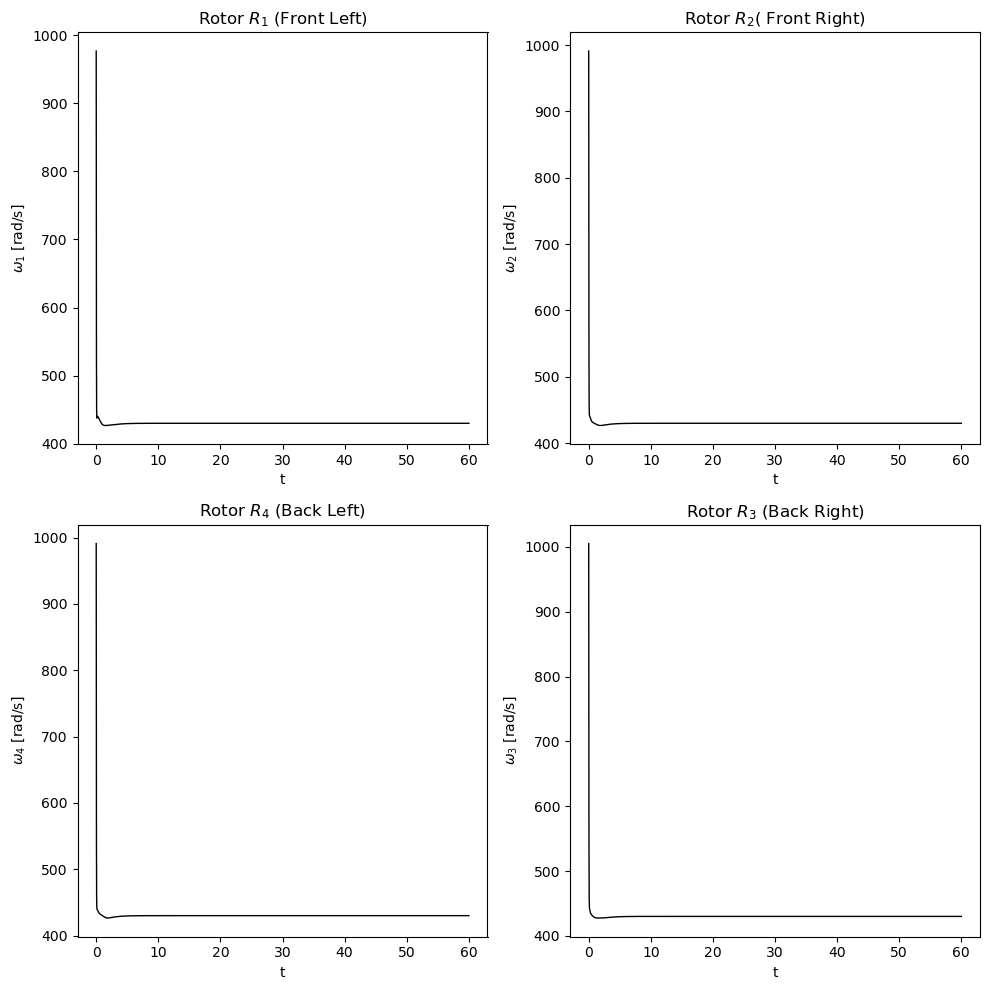

976.528476274823
990.932542789132
1005.13021233144
990.932542789132


In [33]:
# plot motor data over time:
motor_vals2 = np.array(np.real(general_motor2)).T


fig = plt.figure(figsize=(10, 10), tight_layout=True)

axs1 = fig.add_subplot(221)
axs1.plot(data['time'],motor_vals2[0],c='black',lw=1,label='Front left motor (#1)')
axs1.set_title("Rotor $R_1$ (Front Left)")
axs1.set_ylabel("$\omega_1$ [rad/s]")
axs1.set_xlabel("t")
#axs1.set_ylim(420, 460)
#axs1.set_xlim(0, 2)

axs2 = fig.add_subplot(222)
axs2.plot(data['time'],motor_vals2[1],c='black',lw=1,label='Front right motor (#2)')
axs2.set_title("Rotor $R_2$( Front Right)")
axs2.set_ylabel("$\omega_2$ [rad/s]")
axs2.set_xlabel("t")
#axs2.set_ylim(420, 460)
#axs2.set_xlim(0, 2)

axs3 = fig.add_subplot(224)
axs3.plot(data['time'],motor_vals2[2],c='black',lw=1,label='Back right motor (#3)')
axs3.set_title("Rotor $R_3$ (Back Right)")
axs3.set_ylabel("$\omega_3$ [rad/s]")
axs3.set_xlabel("t")
#axs3.set_ylim(420, 460)
#axs3.set_xlim(0, 2)

axs4 = fig.add_subplot(223)
axs4.plot(data['time'],motor_vals2[3],c='black',lw=1,label='Back left motor (#4)')
axs4.set_title("Rotor $R_4$ (Back Left)")
axs4.set_ylabel('$\omega_4$ [rad/s]')
axs4.set_xlabel("t")
#axs4.set_ylim(420, 460)
#axs4.set_xlim(0, 2)

plt.show()

print(np.max(motor_vals2[0]))
print(np.max(motor_vals2[1]))
print(np.max(motor_vals2[2]))
print(np.max(motor_vals2[3]))

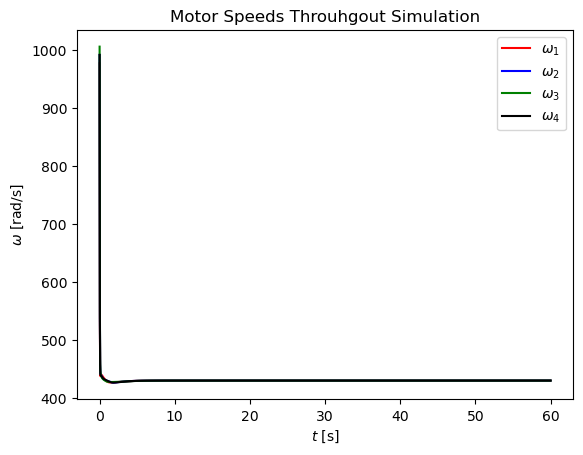

In [34]:
## Plot motor values together to see dependence:

plt.title("Motor Speeds Throuhgout Simulation")
plt.plot(data['time'],motor_vals2[0],c='red',label='$\omega_1$')
plt.plot(data['time'],motor_vals2[1],c='blue',label='$\omega_2$')
plt.plot(data['time'],motor_vals2[2],c='green',label='$\omega_3$')
plt.plot(data['time'],motor_vals2[3],c='black',label='$\omega_4$')
plt.xlabel("$t$ [s]")
plt.ylabel("$\omega$ [rad/s]")
#plt.ylim(429.975, 430.025)
#plt.xlim(21, 25)
plt.legend()
plt.show()

### Plotting Drone's Motion

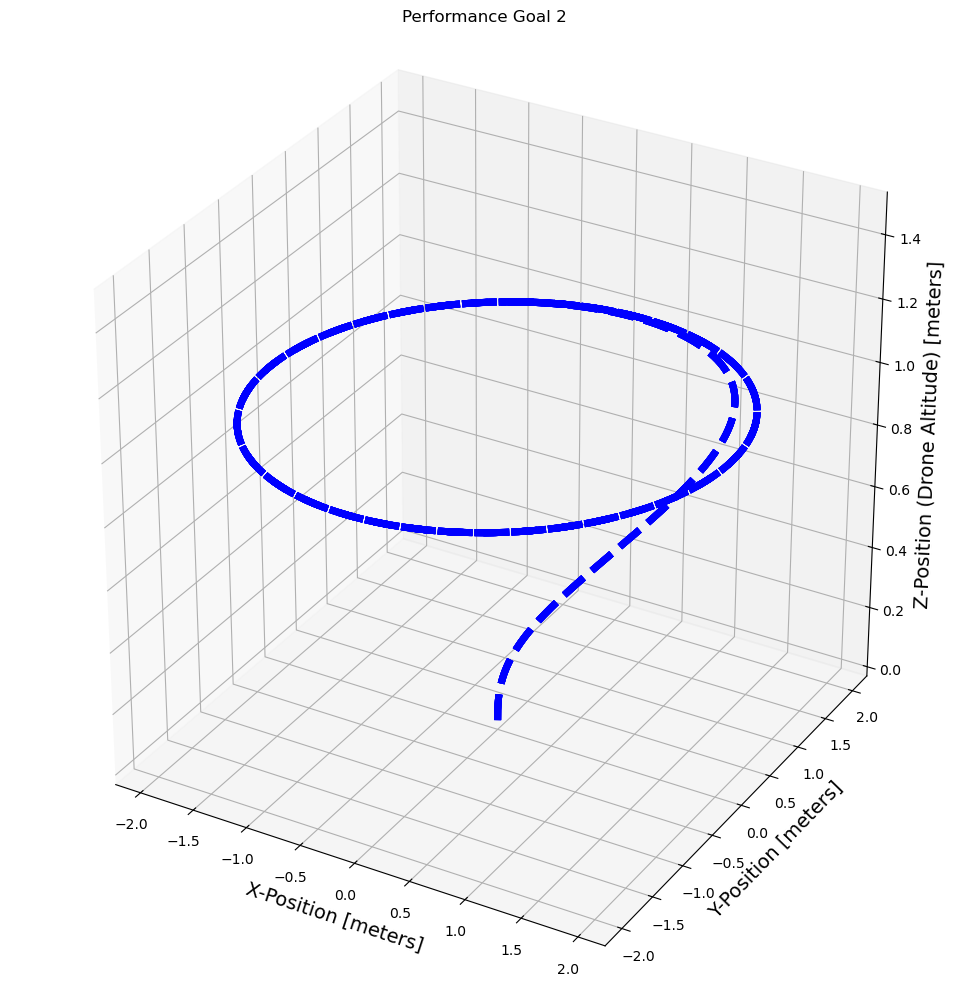

In [35]:
# Create a plot
fig, ax = plt.figure(figsize=(10, 10)), plt.axes(projection = '3d')

# First, extract data for drone position
for n in range(len(data)):
    # Get data for position of drone at diffferent times
    drone_position = np.array(data["position"])
    x_pos = drone_position[:, 0]
    y_pos = drone_position[:, 1]
    z_pos = drone_position[:, 2]

    # Now plot position over time
    ax.plot3D(x_pos, y_pos, z_pos, 'b--', lw = 5.0, label = "Drone Path")
    
# Now add titles
ax.set_xlabel('X-Position [meters]', fontsize = 14)
ax.set_ylabel('Y-Position [meters]', fontsize = 14)
ax.set_zlabel('Z-Position (Drone Altitude) [meters]', fontsize = 14)
ax.grid()
ax.set_box_aspect([1,1,1])
#ax.legend(shadow=True, fancybox=True)
ax.set_title("Performance Goal 2")

ax.set_zlim(0, 1.5)
plt.tight_layout()
plt.show()

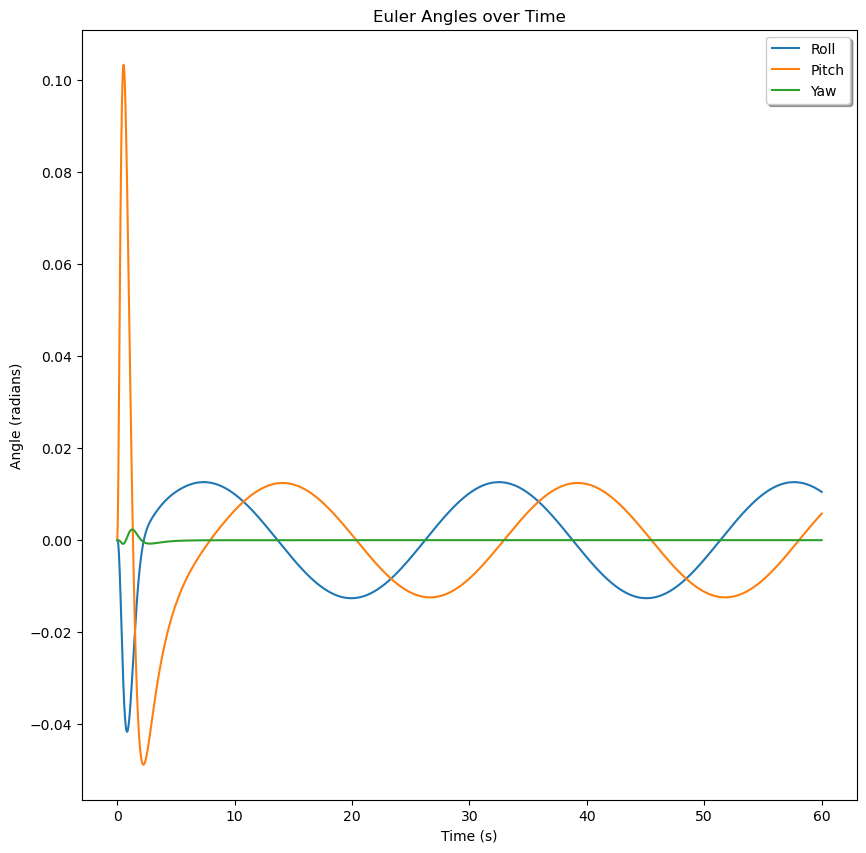

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Extract Euler angles
euler = data["orientation"]

roll = [arr[0] for arr in euler]
pitch = [arr[1] for arr in euler]
yaw = [arr[2] for arr in euler]

# Create a plot with defined size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Euler angles against time
ax.plot(data["time"], roll, label='Roll')
ax.plot(data["time"], pitch, label='Pitch')
ax.plot(data["time"], yaw, label='Yaw')

# Set axis labels
ax.set_xlabel("Time (s)")
ax.set_ylabel("Angle (radians)")

# Set title
ax.set_title("Euler Angles over Time")

# Add a legend with a shadow box
ax.legend(loc='best', shadow=True)  # 'best' places the legend in the optimal position

# Display the plot
plt.show()

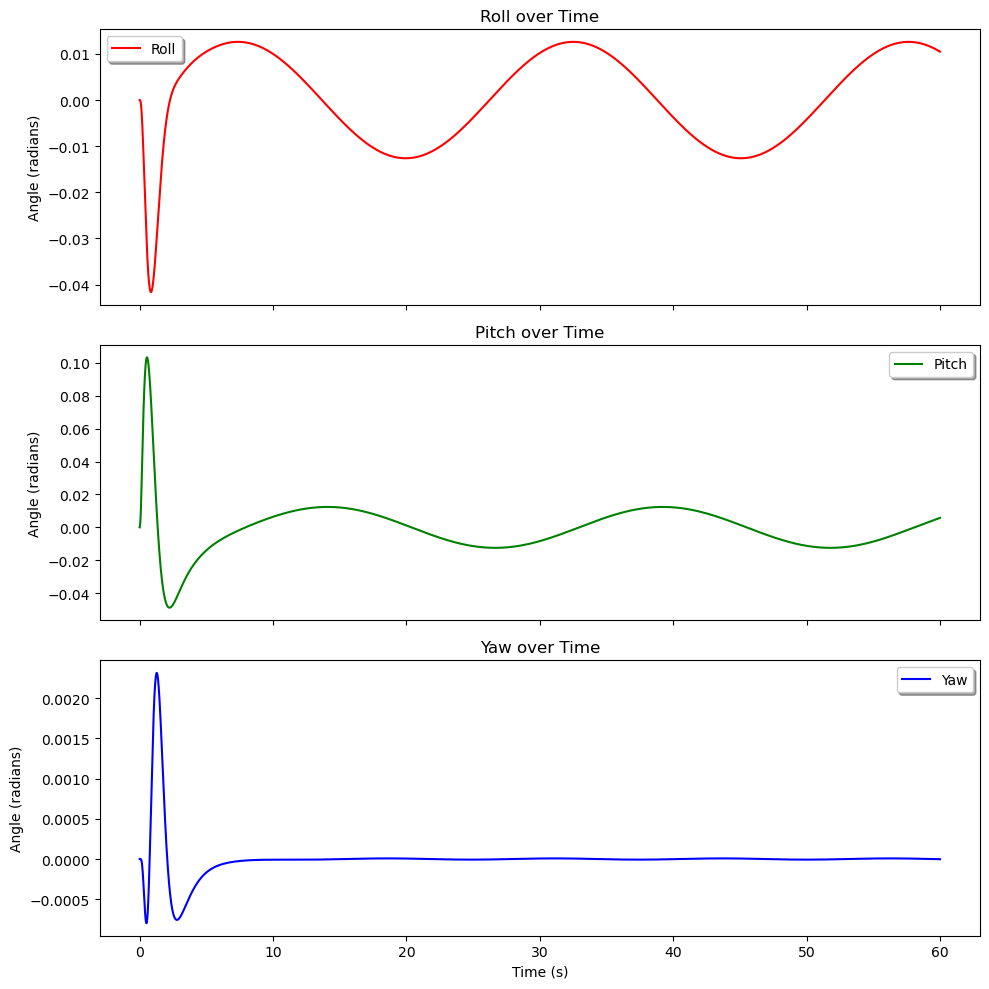

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Extract Euler angles
euler = data["orientation"]

roll = [arr[0] for arr in euler]
pitch = [arr[1] for arr in euler]
yaw = [arr[2] for arr in euler]

# Create a figure with three subplots (1 column and 3 rows)
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)  # sharex=True to share the x-axis

# Subplot for Roll
axes[0].plot(data["time"], roll, color='r', label='Roll')
axes[0].set_ylabel("Angle (radians)")
axes[0].set_title("Roll over Time")
axes[0].legend(loc='best', shadow=True)

# Subplot for Pitch
axes[1].plot(data["time"], pitch, color='g', label='Pitch')
axes[1].set_ylabel("Angle (radians)")
axes[1].set_title("Pitch over Time")
axes[1].legend(loc='best', shadow=True)

# Subplot for Yaw
axes[2].plot(data["time"], yaw, color='b', label='Yaw')
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Angle (radians)")
axes[2].set_title("Yaw over Time")
axes[2].legend(loc='best', shadow=True)

# Show the plot with the three subplots
plt.tight_layout()  # Adjusts subplot params to give some padding
plt.show()


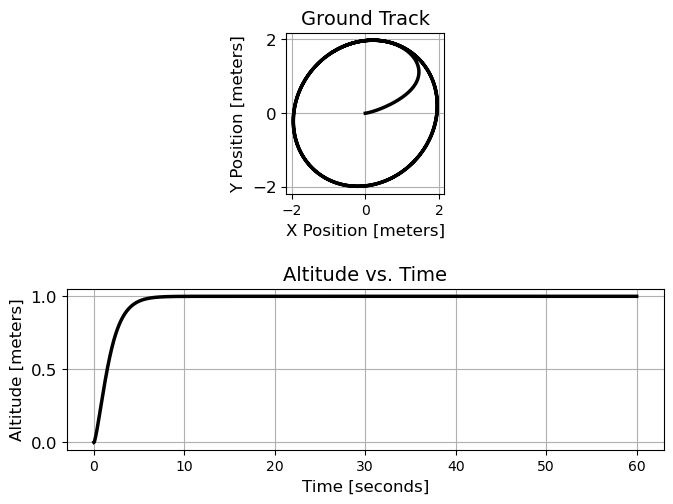

In [38]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=False)

# Convert the position data to array
# Get the position
pos = np.array(data['position'])

# Create a plot of the ground path of the quadrotor
axes[0].plot(pos[:,0], pos[:,1], c="k", lw=2.5)

# Create a plot of the altitude versus time
axes[1].plot(data['time'], pos[:,2], c="k", lw=2.5)

# Make plot 0 pretty
axes[0].set_xlabel("X Position [meters]", fontsize=12)
axes[0].set_ylabel("Y Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].grid()

# Make plot 1 pretty
axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("Altitude [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()

### Verifying Engineering Requirement 3

<class 'list'>
Maximum current drawn by motor is 62.4 amps
Maximum current is within threshold, battery does not overheat


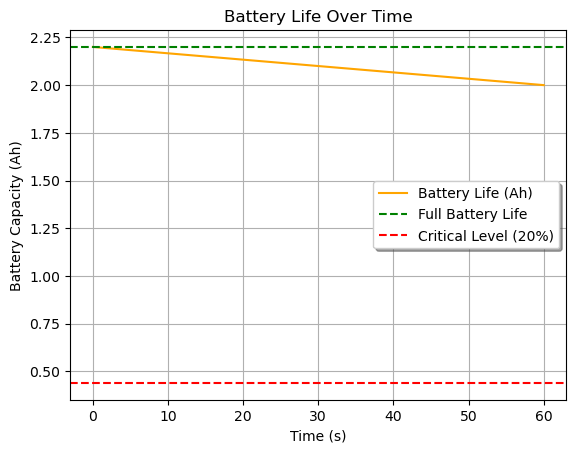

In [39]:
import numpy as np
import matplotlib.pyplot as plt

motor_vals_rpm2 = motor_vals2 * 60 / (2 * np.pi)

time_step = 0.01  # Time step in seconds

# Battery capacity in ampere-hours
battery_capacity_ah = 2.2

# Create function to get amps drawn by battery
def rpm_to_current(rpm_list):
    amp_list = []
    for rpm in rpm_list:
        if rpm <= 5954:
            amps = 3.0
        elif 5954 < rpm <= 7880:
            amps = 6.2
        elif 7880 < rpm <= 9506:
            amps = 14.9
        elif 9506 < rpm <= 10569:
            amps = 17.7
        elif 10569 < rpm <= 11052:
            amps = 23.6
        elif 11052 < rpm:
            amps = 27.2
        amp_list.append(amps)
    return amp_list

# Get lists of amps drawn by each motor
amp_list1 = rpm_to_current(motor_vals_rpm2[0])
print(type(amp_list1))
amp_list2 = rpm_to_current(motor_vals_rpm2[1])
amp_list3 = rpm_to_current(motor_vals_rpm2[2])
amp_list4 = rpm_to_current(motor_vals_rpm2[3])

# Create loss of power due to each motor
battery_life = []
for i in range(len(amp_list1)):
    if i == 0:
        battery_life.append(2.2)
    else:
        battery_loss = (amp_list1[i] + amp_list2[i] + amp_list3[i] + amp_list4[i]) * (time_step / 3600)
        battery_life.append(battery_life[-1] - battery_loss)

# Find maximum current drawn by four motors (done by finding max current for each motor)
max_motor1 = np.max(amp_list1)
max_motor2 = np.max(amp_list2)
max_motor3 = np.max(amp_list3)
max_motor4 = np.max(amp_list4)
max_current = max_motor1 + max_motor2 + max_motor3 + max_motor4
print('Maximum current drawn by motor is', max_current, 'amps')

# Ensure battery does not overheat
if max_current < (35 * 2.2):
    print('Maximum current is within threshold, battery does not overheat')
else:
    print('Maximum current is NOT within threshold, BATTERY OVERHEATS')



# Plot battery life over time
plt.figure()
plt.plot(data["time"], battery_life, color = 'orange', label = "Battery Life (Ah)")
plt.xlabel("Time (s)")
plt.ylabel("Battery Capacity (Ah)")
plt.title("Battery Life Over Time")
plt.axhline(2.2, color = 'green', linestyle = '--', label = 'Full Battery Life')  # Critical level at 20% (2.2 * 0.20)
plt.axhline(0.44, color = 'red', linestyle = '--', label = 'Critical Level (20%)')  # Critical level at 20% (2.2 * 0.20)
plt.legend(shadow = True)
plt.grid(True)
plt.show()

## Performance Goal 3

### Running Simulation and Collecting Data

In [40]:
# Make an instance of the simulator
sim = ae352_quadrotorUAV.Quadrotor_Sim(use_keyboard=True,
                                    visualization=False,
                                    animation=False,
                                    verbose=True)

In [41]:
# Run the simulation and collect the simulation data
data = sim.run(controller3,
               collect_data=True,
               max_time=30.0,
               verbose=True)

Fz is: 58.43804190252604
Fz is: 39.97415520953322
Fz is: 28.49074022754615
Fz is: 21.4647493666907
Fz is: 17.24029791731765
Fz is: 14.747245590914243
Fz is: 13.304610117322273
Fz is: 12.485929344757022
Fz is: 12.030971874216153
Fz is: 11.784532281891284
Fz is: 11.65509319943936
Fz is: 11.589425968332403
Fz is: 11.557103393255144
Fz is: 11.54112250823555
Fz is: 11.53227312765559
Fz is: 11.525788545840154
Fz is: 11.519376743841153
Fz is: 11.512079742744032
Fz is: 11.503624849718282
Fz is: 11.494064585245706
Fz is: 11.483583524430617
Fz is: 11.472399823826958
Fz is: 11.460719114285244
Fz is: 11.448716341720836
Fz is: 11.436531741657827
Fz is: 11.424273335853623
Fz is: 11.412021910421341
Fz is: 11.39983644949518
Fz is: 11.38775910427854
Fz is: 11.375819360997657
Fz is: 11.364037361276527
Fz is: 11.3524264578888
Fz is: 11.340995134040856
Fz is: 11.329748418092752
Fz is: 11.318688911227245
Fz is: 11.30781752517873
Fz is: 11.297134006646726
Fz is: 11.286637306979618
Fz is: 11.276325840906626


### Plotting Angular Velocity of Each Rotor over Time

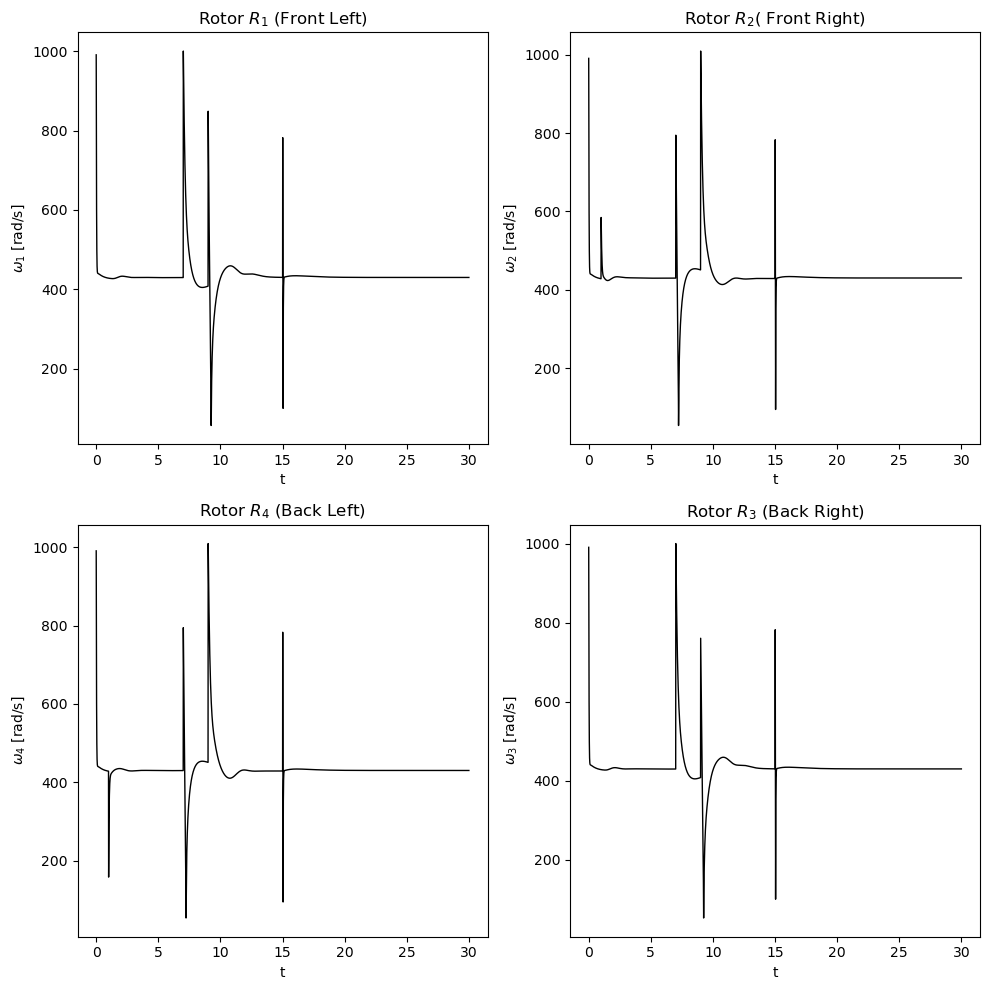

1000.44476820242
1009.59647488720
1000.44476820242
1009.59521041174


In [42]:
# plot motor data over time:
motor_vals3 = np.array(np.real(general_motor3)).T


fig = plt.figure(figsize=(10, 10), tight_layout=True)

axs1 = fig.add_subplot(221)
axs1.plot(data['time'],motor_vals3[0],c='black',lw=1,label='Front left motor (#1)')
axs1.set_title("Rotor $R_1$ (Front Left)")
axs1.set_ylabel("$\omega_1$ [rad/s]")
axs1.set_xlabel("t")
#axs1.set_ylim(420, 460)
#axs1.set_xlim(0, 2)

axs2 = fig.add_subplot(222)
axs2.plot(data['time'],motor_vals3[1],c='black',lw=1,label='Front right motor (#2)')
axs2.set_title("Rotor $R_2$( Front Right)")
axs2.set_ylabel("$\omega_2$ [rad/s]")
axs2.set_xlabel("t")
#axs2.set_ylim(420, 460)
#axs2.set_xlim(0, 2)

axs3 = fig.add_subplot(224)
axs3.plot(data['time'],motor_vals3[2],c='black',lw=1,label='Back right motor (#3)')
axs3.set_title("Rotor $R_3$ (Back Right)")
axs3.set_ylabel("$\omega_3$ [rad/s]")
axs3.set_xlabel("t")
#axs3.set_ylim(420, 460)
#axs3.set_xlim(0, 2)

axs4 = fig.add_subplot(223)
axs4.plot(data['time'],motor_vals3[3],c='black',lw=1,label='Back left motor (#4)')
axs4.set_title("Rotor $R_4$ (Back Left)")
axs4.set_ylabel('$\omega_4$ [rad/s]')
axs4.set_xlabel("t")
#axs4.set_ylim(420, 460)
#axs4.set_xlim(0, 2)

plt.show()

print(np.max(motor_vals3[0]))
print(np.max(motor_vals3[1]))
print(np.max(motor_vals3[2]))
print(np.max(motor_vals3[3]))

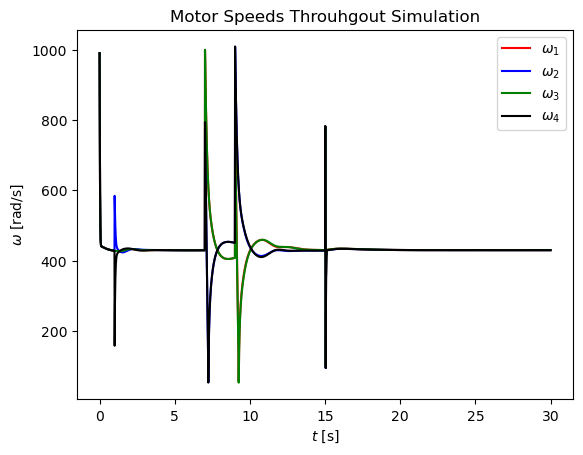

In [43]:
# Plot motor values together to see dependence:

plt.title("Motor Speeds Throuhgout Simulation")
plt.plot(data['time'],motor_vals3[0],c='red',label='$\omega_1$')
plt.plot(data['time'],motor_vals3[1],c='blue',label='$\omega_2$')
plt.plot(data['time'],motor_vals3[2],c='green',label='$\omega_3$')
plt.plot(data['time'],motor_vals3[3],c='black',label='$\omega_4$')
plt.xlabel("$t$ [s]")
plt.ylabel("$\omega$ [rad/s]")
#plt.ylim(429.975, 430.025)
#plt.xlim(21, 25)
plt.legend()
plt.show()

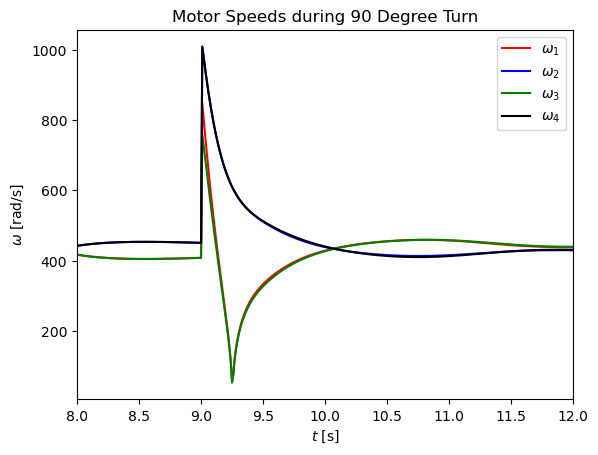

In [50]:
# Plot motor values together to see dependence:

plt.title("Motor Speeds during 90 Degree Turn")
plt.plot(data['time'],motor_vals3[0],c='red',label='$\omega_1$')
plt.plot(data['time'],motor_vals3[1],c='blue',label='$\omega_2$')
plt.plot(data['time'],motor_vals3[2],c='green',label='$\omega_3$')
plt.plot(data['time'],motor_vals3[3],c='black',label='$\omega_4$')
plt.xlabel("$t$ [s]")
plt.ylabel("$\omega$ [rad/s]")
#plt.ylim(429.975, 430.025)
plt.xlim(8, 12)
plt.legend()
plt.show()

### Plotting Drone's Motion

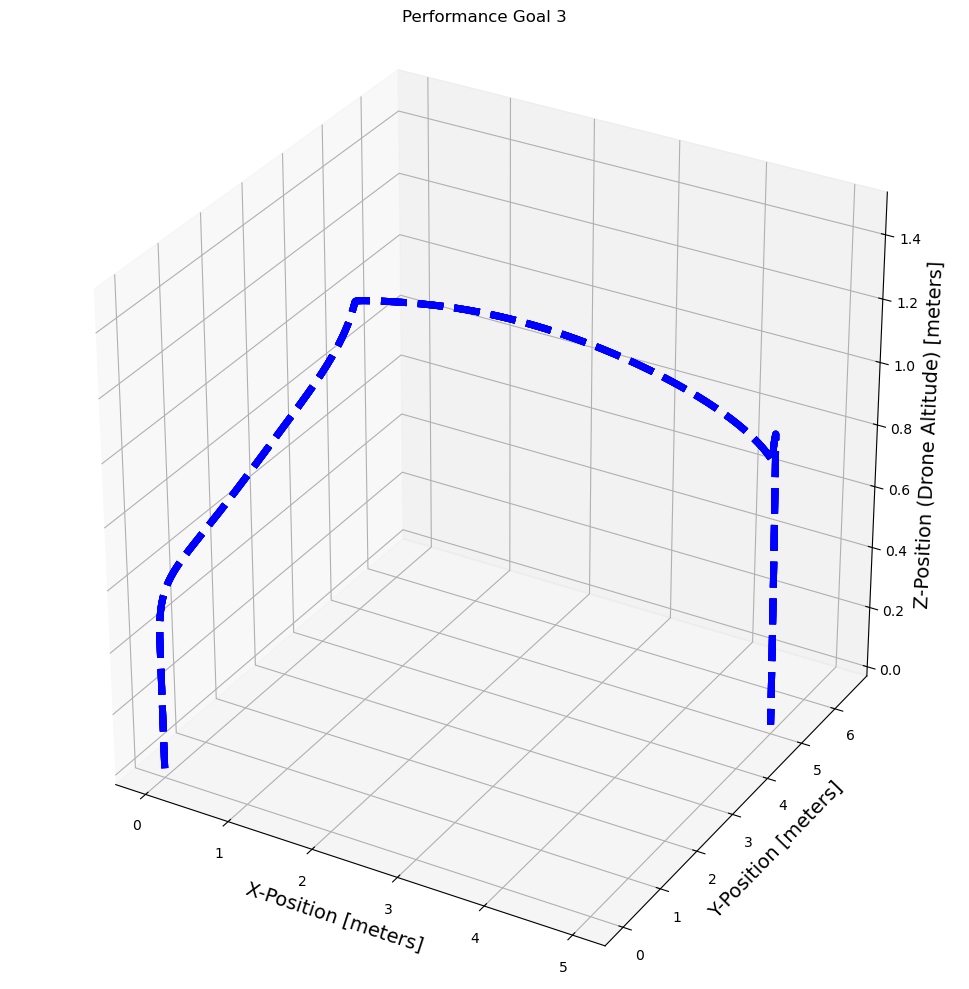

In [45]:
# Create a plot
fig, ax = plt.figure(figsize=(10, 10)), plt.axes(projection = '3d')

# First, extract data for drone position
for n in range(len(data)):
    # Get data for position of drone at diffferent times
    drone_position = np.array(data["position"])
    x_pos = drone_position[:, 0]
    y_pos = drone_position[:, 1]
    z_pos = drone_position[:, 2]

    # Now plot position over time
    ax.plot3D(x_pos, y_pos, z_pos, 'b--', lw = 5.0, label = "Drone Path")
    
# Now add titles
ax.set_xlabel('X-Position [meters]', fontsize = 14)
ax.set_ylabel('Y-Position [meters]', fontsize = 14)
ax.set_zlabel('Z-Position (Drone Altitude) [meters]', fontsize = 14)
ax.grid()
ax.set_box_aspect([1,1,1])
#ax.legend(shadow=True, fancybox=True)
ax.set_title("Performance Goal 3")

# Set limits
ax.set_zlim(0, 1.5)
plt.tight_layout()
plt.show()

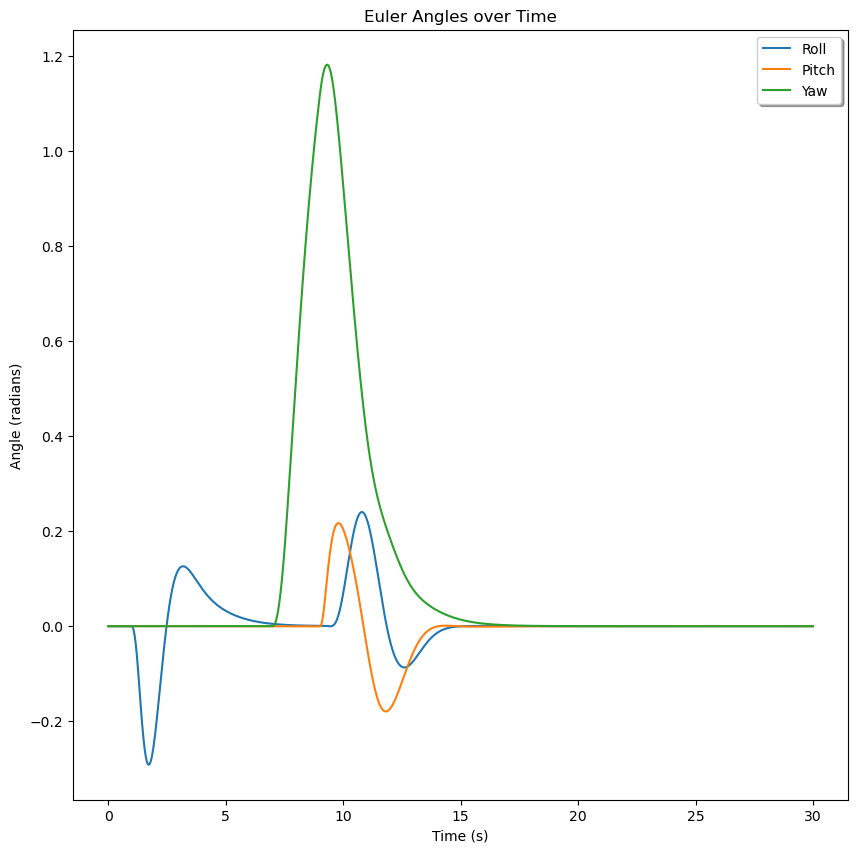

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Extract Euler angles
euler = data["orientation"]

roll = [arr[0] for arr in euler]
pitch = [arr[1] for arr in euler]
yaw = [arr[2] for arr in euler]

# Create a plot with defined size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Euler angles against time
ax.plot(data["time"], roll, label='Roll')
ax.plot(data["time"], pitch, label='Pitch')
ax.plot(data["time"], yaw, label='Yaw')

# Set axis labels
ax.set_xlabel("Time (s)")
ax.set_ylabel("Angle (radians)")

# Set title
ax.set_title("Euler Angles over Time")

# Add a legend with a shadow box
ax.legend(loc='best', shadow=True)  # 'best' places the legend in the optimal position

# Display the plot
plt.show()

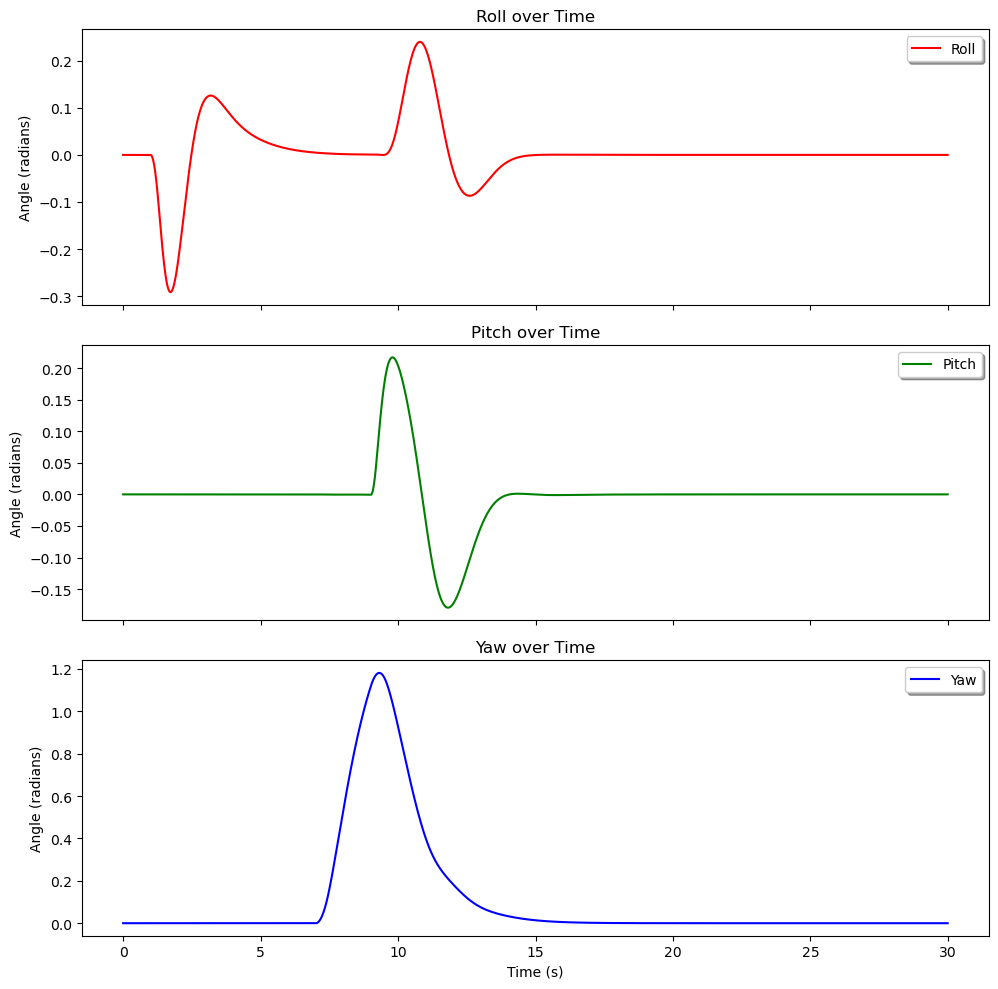

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Extract Euler angles
euler = data["orientation"]

roll = [arr[0] for arr in euler]
pitch = [arr[1] for arr in euler]
yaw = [arr[2] for arr in euler]

# Create a figure with three subplots (1 column and 3 rows)
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)  # sharex=True to share the x-axis

# Subplot for Roll
axes[0].plot(data["time"], roll, color='r', label='Roll')
axes[0].set_ylabel("Angle (radians)")
axes[0].set_title("Roll over Time")
axes[0].legend(loc='best', shadow=True)

# Subplot for Pitch
axes[1].plot(data["time"], pitch, color='g', label='Pitch')
axes[1].set_ylabel("Angle (radians)")
axes[1].set_title("Pitch over Time")
axes[1].legend(loc='best', shadow=True)

# Subplot for Yaw
axes[2].plot(data["time"], yaw, color='b', label='Yaw')
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Angle (radians)")
axes[2].set_title("Yaw over Time")
axes[2].legend(loc='best', shadow=True)

# Show the plot with the three subplots
plt.tight_layout()  # Adjusts subplot params to give some padding
plt.show()


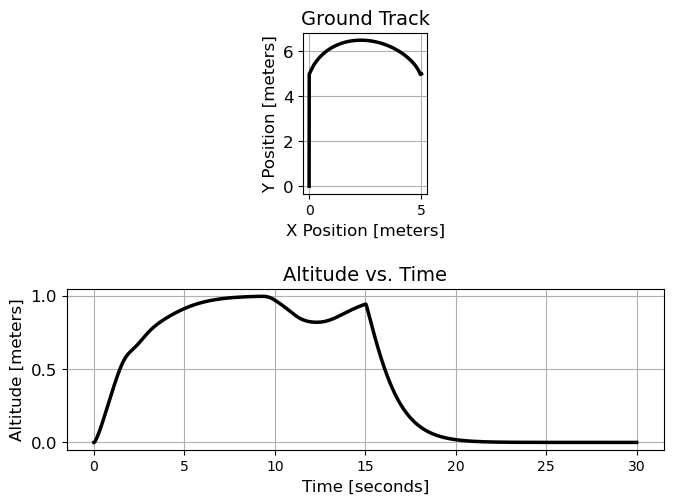

In [48]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=False)

# Convert the position data to array
# Get the position
pos = np.array(data['position'])

# Create a plot of the ground path of the quadrotor
axes[0].plot(pos[:,0], pos[:,1], c="k", lw=2.5)

# Create a plot of the altitude versus time
axes[1].plot(data['time'], pos[:,2], c="k", lw=2.5)

# Make plot 0 pretty
axes[0].set_xlabel("X Position [meters]", fontsize=12)
axes[0].set_ylabel("Y Position [meters]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Ground Track", fontsize=14)
axes[0].set_aspect('equal', 'box')
axes[0].grid()

# Make plot 1 pretty
axes[1].set_xlabel("Time [seconds]", fontsize=12)
axes[1].set_ylabel("Altitude [meters]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Altitude vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()

### Verifying Engineering Requirement 3

<class 'list'>
Maximum current drawn by motor is 70.8 amps
Maximum current is within threshold, battery does not overheat


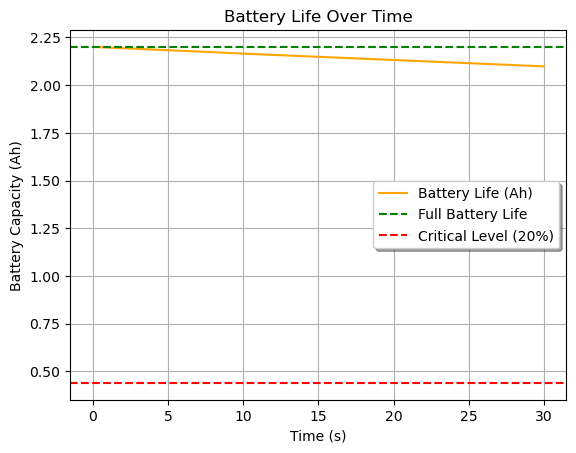

In [49]:
import numpy as np
import matplotlib.pyplot as plt

motor_vals_rpm3 = motor_vals3 * 60 / (2 * np.pi)

time_step = 0.01  # Time step in seconds

# Battery capacity in ampere-hours
battery_capacity_ah = 2.2

# Create function to get amps drawn by battery
def rpm_to_current(rpm_list):
    amp_list = []
    for rpm in rpm_list:
        if rpm <= 5954:
            amps = 3.0
        elif 5954 < rpm <= 7880:
            amps = 6.2
        elif 7880 < rpm <= 9506:
            amps = 14.9
        elif 9506 < rpm <= 10569:
            amps = 17.7
        elif 10569 < rpm <= 11052:
            amps = 23.6
        elif 11052 < rpm:
            amps = 27.2
        amp_list.append(amps)
    return amp_list

# Get lists of amps drawn by each motor
amp_list1 = rpm_to_current(motor_vals_rpm3[0])
print(type(amp_list1))
amp_list2 = rpm_to_current(motor_vals_rpm3[1])
amp_list3 = rpm_to_current(motor_vals_rpm3[2])
amp_list4 = rpm_to_current(motor_vals_rpm3[3])

# Create loss of power due to each motor
battery_life = []
for i in range(len(amp_list1)):
    if i == 0:
        battery_life.append(2.2)
    else:
        battery_loss = (amp_list1[i] + amp_list2[i] + amp_list3[i] + amp_list4[i]) * (time_step / 3600)
        battery_life.append(battery_life[-1] - battery_loss)

# Find maximum current drawn by four motors (done by finding max current for each motor)
max_motor1 = np.max(amp_list1)
max_motor2 = np.max(amp_list2)
max_motor3 = np.max(amp_list3)
max_motor4 = np.max(amp_list4)
max_current = max_motor1 + max_motor2 + max_motor3 + max_motor4
print('Maximum current drawn by motor is', max_current, 'amps')

# Ensure battery does not overheat
if max_current < (35 * 2.2):
    print('Maximum current is within threshold, battery does not overheat')
else:
    print('Maximum current is NOT within threshold, BATTERY OVERHEATS')



# Plot battery life over time
plt.figure()
plt.plot(data["time"], battery_life, color = 'orange', label = "Battery Life (Ah)")
plt.xlabel("Time (s)")
plt.ylabel("Battery Capacity (Ah)")
plt.title("Battery Life Over Time")
plt.axhline(2.2, color = 'green', linestyle = '--', label = 'Full Battery Life')  # Critical level at 20% (2.2 * 0.20)
plt.axhline(0.44, color = 'red', linestyle = '--', label = 'Critical Level (20%)')  # Critical level at 20% (2.2 * 0.20)
plt.legend(shadow = True)
plt.grid(True)
plt.show()